# Train smarter Naive Bayes model with labelled data

The running of this script creates new pickle object with Naive Bayes model. Periodically run the notebook and replace the pickle file in object with a new one as it only gets better with more data.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import ComplementNB
from sklearn.pipeline import Pipeline

In [2]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /home/vlado/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df = pd.read_csv('news.csv', header=None)
df.columns = ['index','date', 'title' ,'text', 'naive_bayes_label', 'neural_net_label', 'checked_label']
df = df[['text', 'checked_label']]
df[df['checked_label'] == 'geberal'] = 'general'
df = df.dropna()
df.shape

(502, 2)

In [4]:
df['checked_label'].value_counts()

web/mobile         193
general            139
job/career          85
devops/OS           41
AI/Data Science     33
finance             11
Name: checked_label, dtype: int64

In [5]:
df2 = pd.read_csv('long_articles.csv', header=None)
df2.columns = ['index', 'date', 'text', 'naive_bayes_label', 'neural_net_label', 'checked_label']
df2 = df2[['text', 'checked_label']]
df2 = df2.dropna()
df2.shape

(957, 2)

We gonna take some finance, ai/data science and devops/os data from another df. This is not a "News" object as 'df' but they are still manually labeled and in the style of the articles so this should solve the under represented distribution.

In [6]:
df = df.append(df2, ignore_index=True)

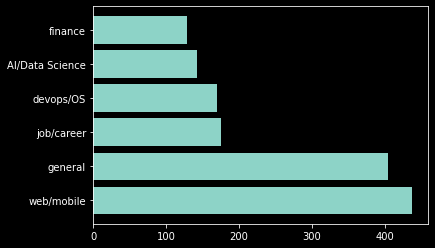

In [7]:
plt.figure(figsize=[6,4])
plt.barh(df['checked_label'].value_counts().index, df['checked_label'].value_counts())
plt.grid(False);

This looks well distributed now. We are going to have to clean the junk out of the text.

In [8]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub(r'\d', '', text)
    text = re.sub(r"&#x27;", "", text)
    text = re.sub(r"&gt;", "", text)
    text = re.sub(r"&#x2F;", "", text)
    text = re.sub(r"<[^>]*>", "", text)
    text = text.strip(' ')
    return text

def remove_stopwords(row):
    final_row = [w for w in row.split(' ') if w not in stopwords.words('english')]
    final_row = ' '.join(final_row)
    return final_row


In [9]:
df['text'] = df['text'].map(clean_text)
df['text'] = df['text'].map(remove_stopwords)

In [10]:
df

,text,checked_label
0,given hundreds dollars breaking federal laws k...,general
1,hello world name nilay cofounder jorge founded...,general
2,early stage maker manage funds expenses full f...,finance
3,e breaking sha encryption,devops/OS
4,hey hn p quinn kristine quadrant eye href http...,general
...,...,...
1454,https xf xf www instanote io p hey hn founder ...,web/mobile
1455,hello x trying create cookie less beside one n...,web/mobile
1456,advice resources run meeting p x rarely seen m...,general
1457,gt python could difficult port web assembly ro...,web/mobile


## Tf-IDF

Here we use Tf IDf which is a method based mainly on the frequency of the words. It's very good with the simpler models that we will be creating  here. 

In [11]:
vectorizer = TfidfVectorizer()
x_train = vectorizer.fit_transform(df['text'])

In [12]:
x_train = x_train.toarray()

In [13]:
df['checked_label'].unique()

array(['general', 'finance', 'devops/OS', 'job/career', 'web/mobile',
       'AI/Data Science'], dtype=object)

In [14]:
df['checked_label'] = df['checked_label'].map({'AI/Data Science': 0, 'devops/OS': 1, 'finance': 2, 
                                               'general': 3, 'job/career': 4,  'web/mobile': 5})
y_train = df['checked_label'] 

In [15]:
x_train.shape, y_train.shape

((1459, 12185), (1459,))

## Split into train - test 


In [16]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [17]:
x_train.shape, y_train.shape

((1167, 12185), (1167,))

In [18]:
x_test.shape, y_test.shape

((292, 12185), (292,))

## Naive Bayes

Very good with text data, sparse matrices and tf-idf.

In [19]:
params = {'alpha': [0, 0.2, 0.5, 0.7, 1, 2, 5], 'norm': [True, False]}

In [20]:
grid = GridSearchCV(ComplementNB(), param_grid = params, n_jobs= -1)
grid.fit(x_train, y_train)
best_scores = grid.best_params_
best_scores

{'alpha': 0.5, 'norm': False}

In [21]:
nb = ComplementNB(alpha = best_scores['alpha'], norm = best_scores['norm'])

In [22]:
nb.fit(x_train, y_train)

ComplementNB(alpha=0.5)

In [23]:
preds = nb.predict(x_test)

In [24]:
def print_metrics(model, predictions):
    print(f'Train Accuracy: {model.score(x_train, y_train)}')
    print(f'Test Accuracy: {model.score(x_test, y_test)}')
    print(f'F1 score: {f1_score(predictions, y_test, average = "weighted")}')

In [25]:
print_metrics(nb, preds)

Train Accuracy: 0.9880034275921166
Test Accuracy: 0.6678082191780822
F1 score: 0.6771374342188458


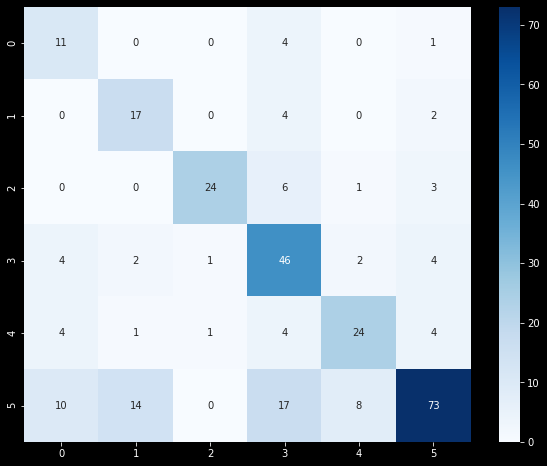

In [26]:
def show_confusion_matrix(predictions):
    conf_matrix = confusion_matrix(predictions, y_test)
    plt.figure(figsize=[10,8])
    sns.heatmap(conf_matrix, annot = True, fmt ='d',cmap = 'Blues');

show_confusion_matrix(preds)

## Save model

Let's create a pipeline that will ease the model when serves in production.

In [27]:
pipe = Pipeline([('vectorizer', TfidfVectorizer()), ('nb', ComplementNB())])
pipe.fit(df['text'] , df['checked_label'] )

Pipeline(steps=[('vectorizer', TfidfVectorizer()), ('nb', ComplementNB())])

In [28]:
def test_with_random_text(txt):
    txt = clean_text(txt)
    txt = remove_stopwords(txt)
    pred = pipe.predict([txt])
    return pred

In [29]:
pred = test_with_random_text('Windows is the worst OS there is. I hope people will soon see the excelence of Linux')
pred

array([1])

In [30]:
pred = test_with_random_text('This is all about politics.This is not in our labels so it should be general')
pred

array([3])

In [31]:
pred = test_with_random_text('This Machine Learning Model required more hyperparameters tuning.')
pred

array([0])

In [32]:
import pickle
save_classifier = open("nb_topic_classifier.pickle","wb")
pickle.dump(pipe, save_classifier)
save_classifier.close()